## Package

In [2]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

from architectures_cifar_32x32.SimpleModels import *
from architectures_cifar_32x32.ConvNet import ConvNet
from architectures_cifar_32x32.KANConvs_MLP import CKAN
from architectures_cifar_32x32.KKAN import KKAN_Convolutional_Network

## Dataset

In [4]:
# Transformaciones
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Cargar MNIST y filtrar por dos clases
mnist_train = CIFAR10(root='./data', train=True, download=True, transform=transform)
mnist_train.data = mnist_train.data.astype('float32') / 255.0

mnist_test = CIFAR10(root='./data', train=False, download=True, transform=transform)
mnist_test.data = mnist_test.data.astype('float32') / 255.0

# DataLoader
train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


## Train & Test

In [7]:
def train(model, device, train_loader, optimizer, epoch, criterion):
    """
    Train the model for one epoch

    Args:
        model: the neural network model
        device: cuda or cpu
        train_loader: DataLoader for training data
        optimizer: the optimizer to use (e.g. SGD)
        epoch: the current epoch
        criterion: the loss function (e.g. CrossEntropy)

    Returns:
        avg_loss: the average loss over the training set
    """

    model.to(device)
    model.train()
    train_loss = 0
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        # Recall that GPU is optimized for the operations we are dealing with
        data, target = data.to(device), target.to(device)
        
        # Reset the optimizer
        optimizer.zero_grad()
        
        # Push the data forward through the model layers
        output = model(data)
        
        # Get the loss
        loss = criterion(output, target)

        # Keep a running total
        train_loss += loss.item()
        
        # Backpropagate
        loss.backward()
        optimizer.step()
        
    # return average loss for the epoch
    avg_loss = train_loss / (batch_idx+1)
    # print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss

def test(model, device, test_loader, criterion):
    """
    Test the model

    Args:
        model: the neural network model
        device: cuda or cpu
        test_loader: DataLoader for test data
        criterion: the loss function (e.g. CrossEntropy)

    Returns:
        test_loss: the average loss over the test set
        accuracy: the accuracy of the model on the test set
        precision: the precision of the model on the test set
        recall: the recall of the model on the test set
        f1: the f1 score of the model on the test set
    """

    model.eval()
    test_loss = 0
    correct = 0
    all_targets = []
    all_predictions = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            
            # Get the predicted classes for this batch
            output = model(data)
            
            # Calculate the loss for this batch
            test_loss += criterion(output, target).item()
            
            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += (target == predicted).sum().item()

            # Collect all targets and predictions for metric calculations
            all_targets.extend(target.view_as(predicted).cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Calculate overall metrics
    precision = precision_score(all_targets, all_predictions, average='macro')
    recall = recall_score(all_targets, all_predictions, average='macro')
    f1 = f1_score(all_targets, all_predictions, average='macro')

    # Normalize test loss
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)

    # print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%), Precision: {:.2f}, Recall: {:.2f}, F1 Score: {:.2f}\n'.format(
    #     test_loss, correct, len(test_loader.dataset), accuracy, precision, recall, f1))

    return test_loss, accuracy, precision, recall, f1

In [8]:
def train_and_test_models(model, device, train_loader, test_loader, optimizer, criterion, epochs, scheduler):
    """
    Train and test the model

    Args:
        model: the neural network model
        device: cuda or cpu
        train_loader: DataLoader for training data
        test_loader: DataLoader for test data
        optimizer: the optimizer to use (e.g. SGD)
        criterion: the loss function (e.g. CrossEntropy)
        epochs: the number of epochs to train
        scheduler: the learning rate scheduler

    Returns:
        all_train_loss: a list of the average training loss for each epoch
        all_test_loss: a list of the average test loss for each epoch
        all_test_accuracy: a list of the accuracy for each epoch
        all_test_precision: a list of the precision for each epoch
        all_test_recall: a list of the recall for each epoch
        all_test_f1: a list of the f1 score for each epoch
    """
    # Track metrics
    all_train_loss = []
    all_test_loss = []
    all_test_accuracy = []
    all_test_precision = []
    all_test_recall = []
    all_test_f1 = []
    
    for epoch in range(1, epochs + 1):
        # Train the model
        train_loss = train(model, device, train_loader, optimizer, epoch, criterion)
        all_train_loss.append(train_loss)
        
        # Test the model
        test_loss, test_accuracy, test_precision, test_recall, test_f1 = test(model, device, test_loader, criterion)
        all_test_loss.append(test_loss)
        all_test_accuracy.append(test_accuracy)
        all_test_precision.append(test_precision)
        all_test_recall.append(test_recall)
        all_test_f1.append(test_f1)

        print(f'End of Epoch {epoch}: Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.0f}%')
        scheduler.step()
    
    return all_train_loss, all_test_loss, all_test_accuracy, all_test_precision, all_test_recall, all_test_f1

## Set Device

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Comon Models

In [ ]:
model_SimpleCNN = SimpleCNN()
model_SimpleCNN.to(device)
optimizer_SimpleCNN = optim.AdamW(model_SimpleCNN.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler_SimpleCNN = optim.lr_scheduler.ExponentialLR(optimizer_SimpleCNN, gamma=0.8)
criterion_SimpleCNN = nn.CrossEntropyLoss()
all_train_loss_SimpleCNN, all_test_loss_SimpleCNN, all_test_accuracy_SimpleCNN, all_test_precision_SimpleCNN, all_test_recall_SimpleCNN, all_test_f1_SimpleCNN = train_and_test_models(model_SimpleCNN, device, train_loader, test_loader, optimizer_SimpleCNN, criterion_SimpleCNN, epochs=10, scheduler=scheduler_SimpleCNN)


In [ ]:
model_SimpleLinear = SimpleLinear()
model_SimpleLinear.to(device)
optimizer_SimpleLinear = optim.AdamW(model_SimpleLinear.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler_SimpleLinear = optim.lr_scheduler.ExponentialLR(optimizer_SimpleLinear, gamma=0.8)
criterion_SimpleLinear = nn.CrossEntropyLoss()
all_train_loss_SimpleLinear, all_test_loss_SimpleLinear, all_test_accuracy_SimpleLinear, all_test_precision_SimpleLinear, all_test_recall_SimpleLinear, all_test_f1_SimpleLinear = train_and_test_models(model_SimpleLinear, device, train_loader, test_loader, optimizer_SimpleLinear, criterion_SimpleLinear, epochs=10, scheduler=scheduler_SimpleLinear)


In [ ]:
model_ConvNet = ConvNet()
model_ConvNet.to(device)
optimizer_ConvNet = optim.AdamW(model_ConvNet.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler_ConvNet = optim.lr_scheduler.ExponentialLR(optimizer_ConvNet, gamma=0.8)
criterion_ConvNet = nn.CrossEntropyLoss()
all_train_loss_ConvNet, all_test_loss_ConvNet, all_test_accuracy_ConvNet, all_test_precision_ConvNet, all_test_recall_ConvNet, all_test_f1_ConvNet = train_and_test_models(model_ConvNet, device, train_loader, test_loader, optimizer_ConvNet, criterion_ConvNet, epochs=10, scheduler=scheduler_ConvNet)


## Convolutional KAN

In [43]:
model_KKAN_Convolutional_Network = KKAN_Convolutional_Network(device = device)
model_KKAN_Convolutional_Network.to(device)
optimizer_KKAN_Convolutional_Network = optim.AdamW(model_KKAN_Convolutional_Network.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler_KKAN_Convolutional_Network = optim.lr_scheduler.ExponentialLR(optimizer_KKAN_Convolutional_Network, gamma=0.8)
criterion_KKAN_Convolutional_Network = nn.CrossEntropyLoss()

all_train_loss_KKAN_Convolutional_Network, all_test_loss_KKAN_Convolutional_Network, all_test_accuracy_KKAN_Convolutional_Network, all_test_precision_KKAN_Convolutional_Network, all_test_recall_KKAN_Convolutional_Network, all_test_f1_KKAN_Convolutional_Network = train_and_test_models(model_KKAN_Convolutional_Network, device, train_loader, test_loader, optimizer_KKAN_Convolutional_Network, criterion_KKAN_Convolutional_Network, epochs=10, scheduler=scheduler_KKAN_Convolutional_Network)


Epoch: 1


  0%|          | 0/782 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 

In [12]:
model_KAN_Convolutional_Network = CKAN(device = device)
model_KAN_Convolutional_Network.to(device)
optimizer_KAN_Convolutional_Network = optim.AdamW(model_KAN_Convolutional_Network.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler_KAN_Convolutional_Network = optim.lr_scheduler.ExponentialLR(optimizer_KAN_Convolutional_Network, gamma=0.8)
criterion_KAN_Convolutional_Network = nn.CrossEntropyLoss()

all_train_loss_KAN_Convolutional_Network, all_test_loss_KAN_Convolutional_Network, all_test_accuracy_KAN_Convolutional_Network, all_test_precision_KAN_Convolutional_Network, all_test_recall_KAN_Convolutional_Network, all_test_f1_KAN_Convolutional_Network = train_and_test_models(model_KAN_Convolutional_Network, device, train_loader, test_loader, optimizer_KAN_Convolutional_Network, criterion_KAN_Convolutional_Network, epochs=10, scheduler=scheduler_KAN_Convolutional_Network)


Epoch: 1


  1%|          | 7/782 [03:25<6:19:35, 29.39s/it]


KeyboardInterrupt: 

## Results

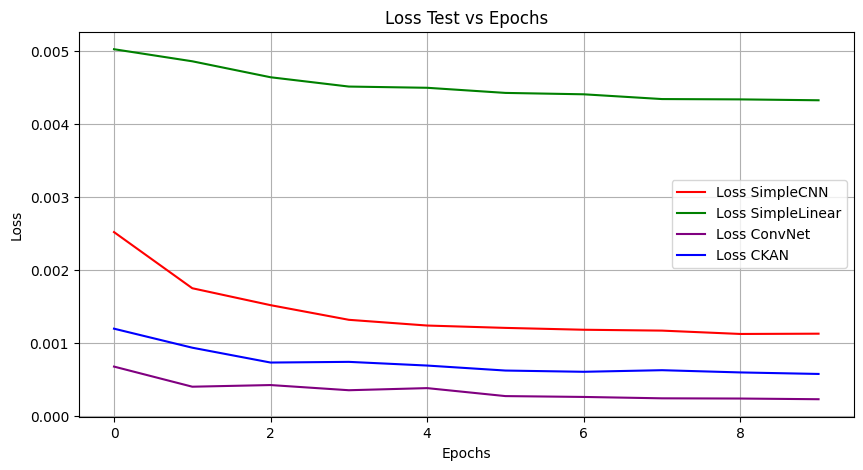

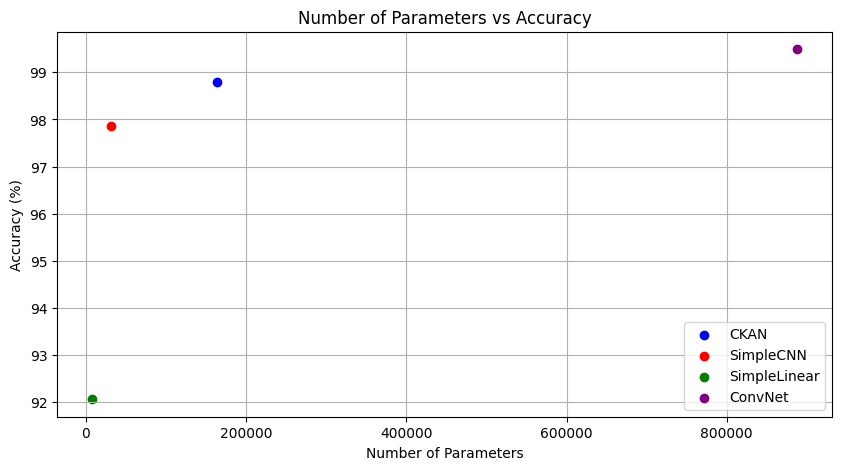

In [42]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

plt.figure(figsize=(10, 5))
plt.plot(all_test_loss_SimpleCNN, label='Loss ConvNet(Small)', color='red')
plt.plot(all_test_loss_SimpleLinear, label='Loss 1 Layer & MLP', color='green')
plt.plot(all_test_loss_ConvNet, label='Loss ConvNet (Big)', color='purple')
plt.plot(all_test_loss_KAN_Convolutional_Network, label='Loss KKAN', color='blue')
# plt.plot(all_test_loss_KKAN_Convolutional_Network, label='Loss KKAN', color='orange')
plt.title('Loss Test vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
# Gráfico de Número de Parámetros vs Exactitud
plt.scatter(count_parameters(model_KAN_Convolutional_Network), max(all_test_accuracy_KAN_Convolutional_Network), color='blue', label='KKAN')
plt.scatter(count_parameters(model_SimpleCNN), max(all_test_accuracy_SimpleCNN), color='red', label='ConvNet(Small)')
plt.scatter(count_parameters(model_SimpleLinear), max(all_test_accuracy_SimpleLinear), color='green', label='1 Layer & MLP')
plt.scatter(count_parameters(model_ConvNet), max(all_test_accuracy_ConvNet), color='purple', label='ConvNet (Big)')
# plt.scatter(count_parameters(model_KKAN_Convolutional_Network), max(all_test_accuracy_KKAN_Convolutional_Network), color='orange', label='KKAN')

plt.title('Number of Parameters vs Accuracy')
plt.xlabel('Number of Parameters')
plt.ylabel('Accuracy (%)')
plt.legend() 
plt.grid(True)
plt.show()


In [1]:
def highlight_max(s):
    is_max = s == s.max()
    return ['font-weight: bold' if v else '' for v in is_max]

accs = []
precision = []
recall = []
f1s = []
params_counts = []

models = [model_SimpleLinear,model_SimpleCNN,model_ConvNet,model_KAN_Convolutional_Network]
all_accuracys = [all_test_accuracy_SimpleLinear,all_test_accuracy_SimpleCNN,all_test_accuracy_ConvNet,all_test_accuracy_KAN_Convolutional_Network]
all_precisions = [all_test_precision_SimpleLinear,all_test_precision_SimpleCNN,all_test_precision_ConvNet,all_test_precision_KAN_Convolutional_Network]
all_recalls = [all_test_recall_SimpleLinear,all_test_recall_SimpleCNN,all_test_recall_ConvNet,all_test_recall_KAN_Convolutional_Network]
all_f1s = [all_test_f1_SimpleLinear,all_test_f1_SimpleCNN,all_test_f1_ConvNet,all_test_f1_KAN_Convolutional_Network]

# accuracy de porcentaje a decimal
for i in range(len(all_accuracys)):
    all_accuracys[i] = [x/100 for x in all_accuracys[i]]
    
for i,m in enumerate(models):
    index = np.argmax(all_accuracys[i])
    params_counts.append(count_parameters(m))
    accs.append(all_accuracys[i][index])
    precision.append(all_precisions[i][index])
    recall.append(all_recalls[i][index])
    f1s.append(all_f1s[i][index])

df = pd.DataFrame({"Test Accuracy":[accs],
                    "Test Precision":[precision],
                    "Test Recall":[recall],
                    "Test F1 Score":[f1s],
                    "Number of Parameters":[params_counts],
                 },index = ["Simple Linear","ConvNet (Small)","ConvNet (Big)","CKAN"])#Rows
df_styled = df.style.apply(highlight_max, subset=df.columns[:], axis=1).format('{:.3f}')

NameError: name 'model_SimpleLinear' is not defined

In [ ]:
df_styled

In [ ]:
latex_table = df_styled.to_latex()

from IPython.display import display, Latex

display(Latex(f"```latex\n{latex_table}\n```"))